In [1]:
import torch
import numpy as np
import argparse
import os
import nibabel
import numpy as np
import mne
import pandas as pd
import mne_bids
from transformers import BertTokenizer, BertModel
import time as tm
from wordfreq import zipf_frequency
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from tqdm import trange
import seaborn as sns

In [2]:
ph_info = pd.read_csv("phoneme_info.csv")
subjects = pd.read_csv("participants.tsv", sep="\t")
subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values

In [3]:
def meg_preprocessing(df_new,raw):
    meta = list()
    for annot in raw.annotations:
        d = eval(annot.pop("description"))
        for k, v in annot.items():
            assert k not in d.keys()
            d[k] = v
        meta.append(d)
    meta = pd.DataFrame(meta)
    meta["intercept"] = 1.0

    # compute voicing
    phonemes = meta.query('kind=="phoneme"')
    assert len(phonemes)
    for ph, d in phonemes.groupby("phoneme"):
        ph = ph.split("_")[0]
        match = ph_info.query("phoneme==@ph")
        assert len(match) == 1
        meta.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

    # compute word frquency and merge w/ phoneme
    meta["is_word"] = False
    words = meta.query('kind=="word"').copy()
    assert len(words) > 10
    # assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
    meta.loc[words.index + 1, "is_word"] = True
    wfreq = lambda x: zipf_frequency(x, "en")  # noqa
    meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

    meta = meta.query('kind=="phoneme"')
    assert len(meta.wordfreq.unique()) > 2

    # segment
    events = np.c_[
        meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
    ].astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=-0.2,
        tmax=0.6,
        decim=10,
        baseline=(-0.2, 0.0),
        metadata=meta,
        preload=True,
        event_repeated="drop",
        picks=["meg"]
    )

    # threshold
    th = np.percentile(np.abs(epochs._data), 95)
    epochs._data[:] = np.clip(epochs._data, -th, th)
    epochs.apply_baseline()
    th = np.percentile(np.abs(epochs._data), 95)
    epochs._data[:] = np.clip(epochs._data, -th, th)
    epochs.apply_baseline()
    
    return epochs

In [4]:
def load_data(sub,ses,task):
    bids_path = mne_bids.BIDSPath(
    subject = sub, session = ses, task=task, datatype= "meg",
    root = '.')
    
    raw = mne_bids.read_raw_bids(bids_path)
    raw.load_data().filter(0.5, 30.0, n_jobs=1)
    
    df = raw.annotations.to_data_frame()
    df_new = pd.DataFrame(df.description.apply(eval).to_list())
    
    ep = meg_preprocessing(df_new, raw)
    
    ep.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(ep))
            ).astype(int)
    ep.metadata["task"] = ses
    ep.metadata["session"] = task
    
    words = ep["is_word"]
    X = words.get_data() * 1e13
    return ep, X

In [5]:
megdata = []
epochs = []
for i in np.arange(4):
    temp = []
    ep, xx = load_data('01','0',str(i))
    megdata.append(xx)
    epochs.append(ep)

Extracting SQD Parameters from sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 395999  =      0.000 ...   395.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff fre

In [45]:
def decod(X, y, meta, times):
    assert len(X) == len(y) == len(meta)
    meta = meta.reset_index()

#     y = scale(y[:, None])[:, 0]
#     if len(set(y[:1000])) > 2:
#         y = y > np.nanmedian(y)
    y = np.argmax(y, axis=1)
    # define data
    model = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
    cv = KFold(5, shuffle=True, random_state=0)

    # fit predict
    n, nchans, ntimes = X.shape
    preds = np.zeros((n, ntimes))
    for t in trange(ntimes):
        preds[:, t] = cross_val_predict(
            model, X[:, :, t], y, cv=cv, method="predict_proba"
        )[:, 1]
    
    # score
    out = list()
    for label, m in meta.groupby("label"):
        Rs = correlate(y[m.index, None], preds[m.index])
        for t, r in zip(times, Rs):
            out.append(dict(score=r, time=t, label=label, n=len(m.index)))
    return pd.DataFrame(out), y, preds

def correlate(X, Y):
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X**2).sum(0) ** 0.5
    SY2 = (Y**2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    return SXY / (SX2 * SY2)


def plot(result):
    fig, ax = plt.subplots(1, figsize=[6, 6])
    sns.lineplot(x="time", y="score", data=result, hue="label", ax=ax)
    ax.axhline(0, color="k")
    return fig

In [104]:
XX = np.load('sub01-meg-data-ses0.npy', allow_pickle=True)
yy = np.load('pos_tags_allstories.npy', allow_pickle=True)

In [105]:
words = epochs[0]["is_word"]
labelnew = (
        "t"
        + words.metadata.task.astype(str)
        + "_s"
        + words.metadata.session.astype(str)
        + "_h"
        + words.metadata.half.astype(str)
    )
words.metadata["label"] = labelnew

In [106]:
label = (
        "t"
        + words.metadata.task.astype(str)
        + "_s"
        + words.metadata.session.astype(str)
        + "_h"
        + words.metadata.half.astype(str)
    )

In [109]:
words.metadata["labelnew"] = label

In [110]:
results = decod(XX[0], yy[0], words.metadata, words.times)

  0%|          | 0/81 [00:00<?, ?it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fi

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
  7%|▋         | 6/81 [00:02<00:37,  2.00it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use cas

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 15%|█▍        | 12/81 [00:05<00:31,  2.17it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation techniq

 28%|██▊       | 23/81 [00:10<00:27,  2.08it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 36%|███▌      | 29/81 [00:13<00:26,  1.99it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 43%|████▎     | 35/81 [00:16<00:21,  2.17it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 51%|█████     | 41/81 [00:19<00:21,  1.82it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 58%|█████▊    | 47/81 [00:22<00:15,  2.15it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 65%|██████▌   | 53/81 [00:25<00:12,  2.17it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 73%|███████▎  | 59/81 [00:28<00:12,  1.70it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation techniq

 86%|████████▋ | 70/81 [00:34<00:05,  1.99it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
 94%|█████████▍| 76/81 [00:37<00:02,  2.00it/s]/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/subbainria/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:1093: RuntimeWarning: Number of classes in training fold (26) does not match total number of classes (27). Results may not be appropriate for your use ca

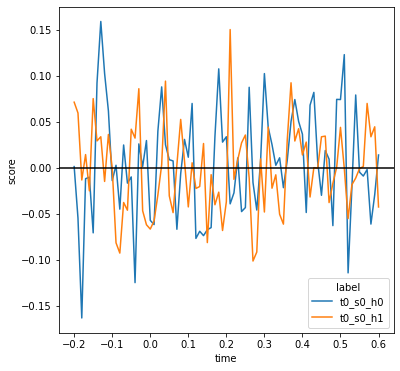

In [111]:
results[0]["subject"] = 'sub1'
results[0]["contrast"] = "Pos-Tags"

fig_decod = plot(results[0])

In [107]:
labels = np.load('features/pos_tags_mappings_all.npy', allow_pickle=True)
stories = np.load('./features/pos_tags_all.npy', allow_pickle=True)
story1 = stories[0:668]
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [108]:
for i in np.arange(story1.shape[0]):
    label.iloc[i] = get_keys_from_value(labels.item(), np.argmax(story1[i]))[0]

In [114]:
words.metadata.reset_index(inplace=True)

In [153]:
acc = 0
for i in np.arange(668):
    print(results[1][i],np.argmax(results[2][i]))
    if results[1][i] == np.argmax(results[2][i]):
        acc+=1

0 33
1 61
2 57
3 29
4 29
5 40
6 1
7 4
7 25
2 45
5 8
6 73
2 73
2 61
8 43
9 72
5 26
6 29
2 12
5 34
6 7
6 9
7 9
7 65
2 46
5 5
7 66
2 77
5 0
6 27
2 32
3 79
1 67
6 79
7 70
2 1
5 5
10 28
2 40
11 8
12 38
1 65
12 23
6 44
2 24
5 44
6 34
2 75
1 0
10 7
7 21
2 28
11 39
12 71
1 34
13 49
7 10
12 22
1 55
6 8
2 32
5 23
2 5
14 33
1 37
5 75
12 8
5 61
12 38
1 11
6 11
2 17
5 1
4 49
15 56
6 2
7 4
2 60
3 55
2 14
3 11
16 79
2 33
4 76
3 15
8 33
9 52
7 51
2 32
17 13
6 79
2 1
7 0
3 32
16 63
8 13
3 19
7 16
3 12
16 50
5 9
4 39
5 47
2 50
7 22
11 68
7 42
13 31
6 50
13 76
5 13
6 61
2 32
13 1
11 30
7 45
2 11
7 31
5 68
6 48
7 14
2 69
2 72
1 20
2 41
3 17
18 55
7 69
4 28
2 46
12 47
17 58
12 31
19 60
9 49
3 8
3 51
5 50
6 61
2 34
17 31
16 17
3 64
2 59
5 16
7 9
2 31
2 55
5 66
2 34
9 14
10 51
6 38
2 49
11 63
3 76
3 33
11 63
9 50
2 8
5 28
12 28
20 14
12 76
18 74
0 58
5 50
15 56
6 79
6 30
2 13
5 64
13 44
5 10
0 73
1 68
4 61
10 33
2 4
13 18
21 69
12 63
18 4
5 2
3 44
4 59
13 8
12 59
1 77
8 0
10 48
2 6
4 6
10 51
7 34
2 36
5 68
6

In [158]:
np.where(results[2][0]>0.05)

(array([ 1, 11, 25, 31, 33, 54, 56, 64, 71, 80]),)